# 1. Notebook Setup

Import libraries

In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from math import sqrt
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sys.path.append("/home/jovyan/Solar-Irradiance-Forecasting/src/")
import eda as eda
import helpers as hlp

Importing plotly failed. Interactive plots will not work.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Loading and Prepare data

Load CSV file that contains GHI

In [5]:
df = pd.read_csv("../../data/Folsom_irradiance.csv", infer_datetime_format=True)
df

,timeStamp,ghi,dni,dhi
0,2014-01-02 08:00:00,0.0,0.0,0.0
1,2014-01-02 08:01:00,0.0,0.0,0.0
2,2014-01-02 08:02:00,0.0,0.0,0.0
3,2014-01-02 08:03:00,0.0,0.0,0.0
4,2014-01-02 08:04:00,0.0,0.0,0.0
...,...,...,...,...
1552315,2016-12-31 07:55:00,0.0,0.0,0.0
1552316,2016-12-31 07:56:00,0.0,0.0,0.0
1552317,2016-12-31 07:57:00,0.0,0.0,0.0
1552318,2016-12-31 07:58:00,0.0,0.0,0.0


In [6]:
df = df[["timeStamp", "ghi"]]

In [9]:
# Split data into train and test based on the years
test_start = "2016-01-01"

df_test = df.loc[df["timeStamp"] >= test_start]

Calculate the persistence forecast by shifting the irradiance values by one time step


In [21]:
df_test['persistence_forecast'] = df_test['ghi'].shift(20)
df_test = df_test.fillna(0.0)
df_test

,timeStamp,ghi,persistence_forecast
1029600,2016-01-01 08:00:00,0.0,0.0
1029601,2016-01-01 08:01:00,0.0,0.0
1029602,2016-01-01 08:02:00,0.0,0.0
1029603,2016-01-01 08:03:00,0.0,0.0
1029604,2016-01-01 08:04:00,0.0,0.0
...,...,...,...
1552315,2016-12-31 07:55:00,0.0,0.0
1552316,2016-12-31 07:56:00,0.0,0.0
1552317,2016-12-31 07:57:00,0.0,0.0
1552318,2016-12-31 07:58:00,0.0,0.0


In [28]:
col_names = []
for i in range(0, 21, 1):
    col_names.append(f"{i} min")
df_20_min_forecast = pd.DataFrame(columns=col_names)
df_20_min_forecast

for i in range(0, len(df_test), 1000):
    time_step = i # 220000
    predictions = list()

    df_time_step = df_test.iloc[time_step:time_step + 21]
    df_time_step["rmse"] = df_time_step.apply(lambda row: sqrt(mean_squared_error([row['ghi']], [row['persistence_forecast']])), axis=1)    
    minutely_rmse = df_time_step["rmse"].values
    df_20_min_forecast = pd.concat([df_20_min_forecast, pd.DataFrame([minutely_rmse], columns=col_names)], ignore_index=True)
    
df_20_min_forecast.loc['mean'] = df_20_min_forecast.mean()

/tmp/ipykernel_28294/780479030.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_step["rmse"] = df_time_step.apply(lambda row: sqrt(mean_squared_error([row['ghi']], [row['persistence_forecast']])), axis=1)
/tmp/ipykernel_28294/780479030.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_step["rmse"] = df_time_step.apply(lambda row: sqrt(mean_squared_error([row['ghi']], [row['persistence_forecast']])), axis=1)
/tmp/ipykernel_28294/780479030.py:12: SettingWithCopyWarning: 
A value is tryi

Plot

In [52]:
x_ticks

range(0, 21)

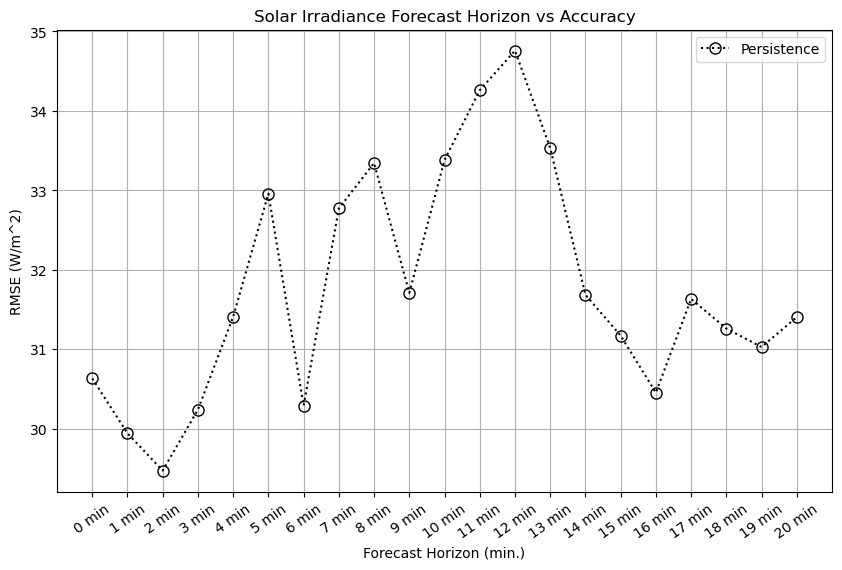

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_20_min_forecast.loc["mean"].T, label='Persistence', color='black', linestyle="dotted", marker='o', markerfacecolor='none', markersize=8)

plt.xticks(rotation=35)

plt.xlabel('Forecast Horizon (min.)')
plt.ylabel('RMSE (W/m^2)')
plt.title('Solar Irradiance Forecast Horizon vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()